# Implementation of question number 1

In [101]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.special import logsumexp


In [103]:
def onehot(y, n_classes):
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

# Define NN class

In [108]:
np.random.seed(42)

class WeightInitializer(object):
    def __init__(self):
        pass

    def initialize_weights(self, dims):
        pass

class ZeroInitializer(WeightInitializer):
    name = "Zero"
    def initialize_weights(self, dims):
        weights = []
        for dim in dims:
            weights.append((np.zeros(dim[0]), np.zeros(dim)))

        return weights

class NormalInitializer(WeightInitializer):
    name = "Normal"
    def initialize_weights(self, dims):
        weights = []
        for dim in dims:
            weights.append((np.zeros(dim[0]), np.random.normal(0.0, 1.0, dim)))

        return weights

class GlorotInitializer(WeightInitializer):
    name = "Glorot"
    def initialize_weights(self, dims):
        weights = []
        for dim in dims:
            weight_range = np.sqrt(6. / (dim[0] + dim[1]))
            weights.append((np.zeros(dim[0]), np.random.uniform(-weight_range, weight_range, size = dim)))

        return weights

# Currently this class only works with nets of exactly 2 hidden layers
class NN:
    def __init__(self, hidden_dims=(1024,2048), n_hidden=2, mode='train', weight_initer = GlorotInitializer(), 
        input_size = 2, output_size= 3):
        print("hidden dims inside NN is ", hidden_dims)
        self.hidden_dims = hidden_dims
        self.n_hidden = n_hidden
        self.weight_initer = weight_initer
        
        dims = [(hidden_dims[0], input_size), 
                (hidden_dims[1], hidden_dims[0]),
                (output_size, hidden_dims[1])]

        params = self.weight_initer.initialize_weights(dims)
        self.b1, self.W1 = params[0]
        self.b2, self.W2 = params[1]
        self.b3, self.W3 = params[2]
        self.parameters = [self.b1, self.W1, self.b2, self.W2, self.b3, self.W3]
        
    def forward(self, x):
        if len(x.shape) == 1:
            x = x[None]
        ha_1 = np.dot(x, self.W1.T) + self.b1
        hs_1 = self.activation(ha_1)
                
        ha_2 = np.dot(hs_1, self.W2.T) + self.b2
        hs_2 = self.activation(ha_2)
                
        oa = np.dot(hs_2, self.W3.T) + self.b3
        
        os = self.softmax(oa, axis=1)
        
        return ha_1, hs_1, ha_2, hs_2, oa, os

    def softmax(self, inp, axis = 1):
        e_x = np.exp(inp - np.max(inp, axis=axis, keepdims=True))
        return e_x / e_x.sum(axis=axis, keepdims=True)
    
    def backward(self, y, x, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay=0):
        if len(x.shape) == 1:
            x = x[None]
            
        bs = x.shape[0]
        dl_doa = os - y
        
        dl_dW3 = np.dot(dl_doa.T, hs_2) / bs + weight_decay * self.W3
        dl_db3 = dl_doa.mean(axis=0)
        
        dl_dhs_2 = np.dot(dl_doa, self.W3)
        dl_dha_2 = (ha_2 > 0) * dl_dhs_2
        
        dl_dW2 = np.dot(dl_dha_2.T, hs_1) / bs + weight_decay * self.W2
        dl_db2 = dl_dha_2.mean(axis=0)
        
        d1_dhs_1 = np.dot(dl_dha_2, self.W2)
        dl_dha_1 = (ha_1 > 0) * d1_dhs_1
        
        dl_dW1 = np.dot(dl_dha_1.T, x) / bs + weight_decay * self.W1
        dl_db1 = dl_dha_1.mean(axis=0)
        
        return dl_db1, dl_dW1, dl_db2, dl_dW2, dl_db3, dl_dW3
    
    def finite_diff(self, x, y, eps=1e-5):
        p = self.parameters[3]
        grad_fdiff = np.zeros(shape=p.shape)
        for index, v in np.ndenumerate(p):                
            p[index] += eps
            _, _, _, _, _, os_plus = self.forward(x)
            loss_diff_plus = self.loss(os_plus, y)
            p[index] -= 2*eps
            _, _, _, _, _, os_minus = self.forward(x)
            loss_diff_minus = self.loss(os_minus, y)
            grad_fdiff[index] = (loss_diff_plus - loss_diff_minus) / float(2*eps)
            p[index] += eps
            
        return grad_fdiff
    
    def activation(self, inp):
        return (inp > 0) * inp

    def loss(self, oa, y):
        log_of_softmax = oa - logsumexp(oa, axis = 1, keepdims = True)
        return (y * (-log_of_softmax)).sum(axis=1).mean(axis=0)

    def update(self, grads, learning_rate):
        for p, grad in zip(self.parameters, grads):
            updt = learning_rate * grad
            p -= updt   
        
    def train(self, data, target, mb_size=100, learning_rate=1e-2, weight_decay=0.):
        for i in range(data.shape[0] // mb_size):
            xi = data[i*mb_size:(i+1)*mb_size]
            yi = target[i*mb_size:(i+1)*mb_size]
            ha_1, hs_1, ha_2, hs_2, oa, os = self.forward(xi)
            average_grads = self.backward(yi, xi, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay)
            average_loss = self.loss(oa, yi)
            self.update(average_grads, learning_rate)
        return average_loss
    
    def test(self, x, y):
        _, _, _, _, _, os = self.forward(x)
        return self.loss(os, y), os.argmax(axis=1)

# Loading MNIST dataset

In [105]:
from random import shuffle

# mnist_data = mnist_reader.load_mnist('mnist/raw/', kind='train')
mnist_data = np.load('./mnist/mnist.pkl', encoding='latin1')

X_train, y_train = mnist_data[0]
X_valid, y_valid = mnist_data[1]
X_test, y_test = mnist_data[2]

X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
X_test = X_test.astype("float32")

print('len X train ', len(X_train))
print('len y train ', len(y_train))
print('len X valid ', len(X_valid))
print('len y valid ', len(y_valid))
print('len X test ', len(X_test))
print('len y test ', len(y_test))

indices = list(range(len(X_train)))
shuffle(indices)

y_train_onehot = onehot(y_train, 10)
y_valid_onehot = onehot(y_valid, 10)
y_test_onehot = onehot(y_test, 10)

len X train  50000
len y train  50000
len X valid  10000
len y valid  10000
len X test  10000
len y test  10000


hidden dims inside NN is  (512, 512)
Epsilon values to try: [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
True gradients = [0.02952565 0.03195459 0.         0.         0.01264355 0.
 0.         0.01292982 0.01203646 0.02146248]
gradient estimates = [0.0151219  0.01635861 0.         0.         0.00657469 0.
 0.         0.00671892 0.0062689  0.01102904]
max_diff = 0.015595985015363314
gradient estimates = [0.01706615 0.01828285 0.         0.         0.00861445 0.
 0.         0.00875769 0.00831068 0.01302841]
max_diff = 0.0136717431109903
gradient estimates = [0.02952565 0.03195459 0.         0.         0.01264355 0.
 0.         0.01292982 0.01203646 0.02146248]
max_diff = 8.950197527557435e-11
gradient estimates = [0.02952565 0.03195459 0.         0.         0.01264355 0.
 0.         0.01292982 0.01203646 0.02146248]
max_diff = 9.061779104868606e-13
gradient estimates = [0.02952565 0.03195459 0.         0.         0.01264355 0.
 0.         0.01292982 0.01203646 0.02146248]
max_diff = 1.79119913

Text(0.5, 0, 'N')

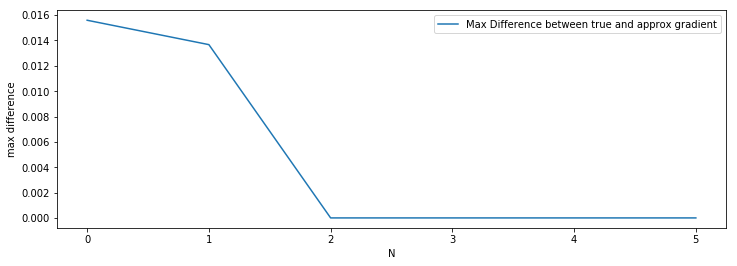

In [33]:
import math

x1 = X_train[0]
y1 = y_train_onehot[0]

mlp = NN(hidden_dims = (414, 414), weight_initer = GlorotInitializer(), input_size = 784, output_size = 10)
ha_1, hs_1, ha_2, hs_2, oa, os = mlp.forward(x1)

# grab the true gradients for the weights of the first layer
true_gradients = mlp.backward(y1, x1, ha_1, hs_1, ha_2, hs_2, oa, os)

N = 5
chosen_epsilon = [1 / float(math.pow(10, n)) for n in range(0, N + 1)]

print(f"Epsilon values to try: {chosen_epsilon}")
print(f"True gradients = {true_gradients[3].flatten()[:10]}")

max_differences = []
for eps in chosen_epsilon:
    finite_diff_grad = mlp.finite_diff(x1,y1, eps=eps)
    print(f"gradient estimates = {finite_diff_grad.flatten()[:10]}")
    difference = np.abs(finite_diff_grad.flatten()[:10] - true_gradients[3].flatten()[:10])
    max_diff = np.max(difference)
    print(f"max_diff = {max_diff}")
    
    max_differences.append(max_diff)
    
plt.figure(figsize=(12, 4))
plt.plot([math.pow(10, n) for n in range(0, N + 1)], max_differences, label='Max Difference between true and approx gradient')
plt.legend()
plt.ylabel('max difference')
plt.xlabel('N')

Text(0.5, 1.0, 'Plot of the maximum difference between the true and approximate gradients as a function of N')

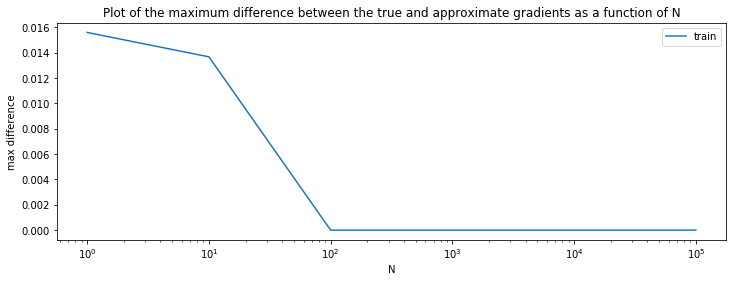

In [36]:
plt.figure(figsize=(12, 4))
plt.plot([math.pow(10, n) for n in range(0, N + 1)], max_differences, label='train')
plt.legend()
plt.ylabel('max difference')
plt.xlabel('N')
plt.xscale('log')
plt.title("Plot of the maximum difference between the true and approximate gradients as a function of N")

# Compute train/valid/test loss and accuracy and display training curves

hidden dims inside NN is  (414, 414)
hidden dims inside NN is  (414, 414)
hidden dims inside NN is  (414, 414)


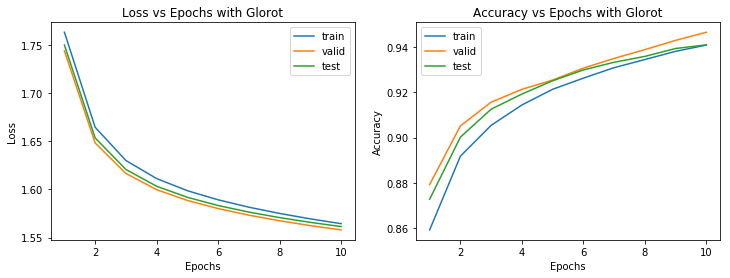

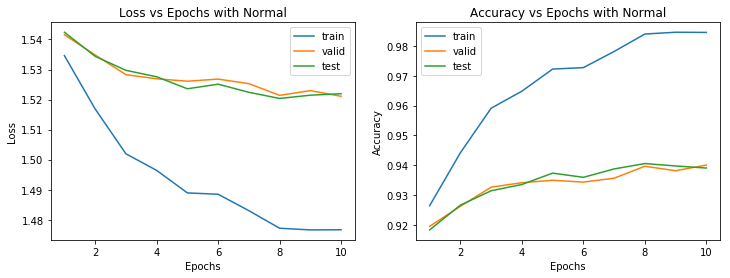

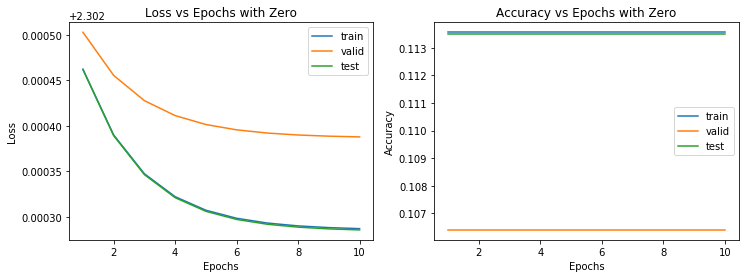

In [109]:
def run_experiment(num_epochs, weight_initer_name, mlp):
    train_accuracies, train_losses = [], []
    valid_accuracies, valid_losses = [], []
    test_accuracies, test_losses = [], []

    for e in range(num_epochs):
        loss = mlp.train(X_train, y_train_onehot, mb_size=100)
        loss_train, pred_train = mlp.test(X_train, y_train_onehot)
        loss_valid, pred_valid = mlp.test(X_valid, y_valid_onehot)
        loss_test, pred_test = mlp.test(X_test, y_test_onehot)

        valid_losses.append(loss_valid)
        test_losses.append(loss_test)
        valid_accuracies.append((pred_valid == y_valid).mean())
        test_accuracies.append((pred_test == y_test).mean())
        train_losses.append(loss_train)
        train_accuracies.append((pred_train == y_train).mean())
        
    ## Loss figure
    plt.figure(figsize=(12, 4))
    axis = plt.subplot(1, 2, 1)
    axis.plot(range(1, len(train_losses)+1), train_losses, label='train')
    axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid')
    axis.plot(range(1, len(test_losses)+1), test_losses, label='test')
    axis.legend()
    axis.set_ylabel('Loss')
    axis.set_xlabel('Epochs')
    axis.set_title('Loss vs Epochs with {}'.format(weight_initer_name))

    # Accuracy figure
    axis = plt.subplot(1, 2, 2)
    axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train')
    axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid')
    axis.plot(range(1, len(test_accuracies)+1), test_accuracies, label='test')
    axis.legend()
    axis.set_ylabel('Accuracy')
    axis.set_xlabel('Epochs')
    axis.set_title('Accuracy vs Epochs with {}'.format(weight_initer_name))
    
    plt.savefig('{}.png'.format(weight_initer_name))

        
weight_initers = [GlorotInitializer(), NormalInitializer(), ZeroInitializer()]
for weight_initer in weight_initers:
    mlp = NN(hidden_dims = (414, 414), weight_initer = weight_initer, input_size = 784, output_size = 10)
    run_experiment(10, weight_initer.name, mlp)